# CLIP Pipeline

## Preparation

In [1]:
import sys, os

# sys path hack to allow importing the encoding functions and other modules
sys.path.insert(0, os.path.abspath('../encoding'))
sys.path.insert(0, os.path.abspath('../viper'))

In [2]:
import torch 

if torch.cuda.is_available():
    gpu = torch.device("cuda")
elif torch.backends.mps.is_available():
    gpu = torch.device("mps")
else:
    print("Warning: no GPU detected, falling back to CPU")
    gpu = torch.device("cpu")

In [3]:
# Clean old model from cache
if 'model' in locals() or 'model' in globals():
    del model
torch.cuda.empty_cache()

from models.clip_model import CLIPModel
model = CLIPModel(gpu)

# from models.xvlm_model import XVLMModel
# model = XVLMModel(gpu)

/home/guests/jhadl/.conda/envs/jhadl_tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-02 22:16:48.908264: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 22:16:48.933591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:16:49.350920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not f

### Reference Question

What is the pan on? -> oven
select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]


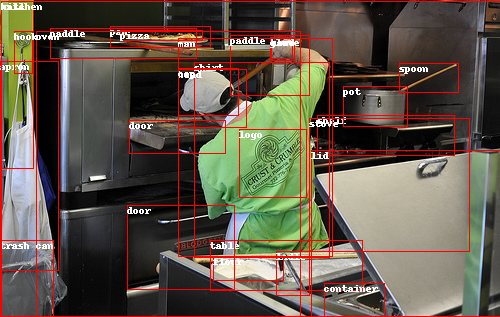

In [4]:
from PIL import Image, ImageDraw
import json

with open("../data/questions/train_sampled_questions_2000.json") as f:
   questions = list(json.load(f).items())

qid, question = questions[3]
print(f"{question['question']} -> {question['answer']}")
print(question['semanticStr'])
image = Image.open(f"../data/images/{question['imageId']}.jpg")

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in question['sceneGraph']['objects'].values():
   object_crop = image.crop((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']))
   draw.rectangle((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']), outline="red", width=1)
   draw.text((object['x'], object['y']), object["name"], fill="white")

imgcopy

## Concept Extraction

In [5]:
import json 
import re
from pattern.text.en import singularize

with open('../data/metadata/gqa_all_attribute.json') as f:
    all_attributes = json.load(f)

def sanitize(name):
    # source: DFOL-VQA
    plurale_tantum = ['this', 'yes', 'pants', 'shorts', 'glasses', 'scissors', 'panties', 'trousers', 'binoculars', 'pliers', 'tongs',\
        'tweezers', 'forceps', 'goggles', 'jeans', 'tights', 'leggings', 'chaps', 'boxers', 'indoors', 'outdoors', 'bus', 'octapus', 'waitress',\
        'pasta', 'pita', 'glass', 'asparagus', 'hummus', 'dress', 'cafeteria', 'grass', 'class']

    irregulars = {'shelves': 'shelf', 'bookshelves': 'bookshelf', 'olives': 'olive', 'brownies': 'brownie', 'cookies': 'cookie'}
    
    temp = name.strip().lower()
    if temp in irregulars:
        temp = irregulars[temp]
    elif not (temp.split(' ')[-1] in plurale_tantum or temp[-2:] == 'ss'):
        temp = singularize(temp)
        
    return temp


def cleanup_whitespace(name):
    cleanup_regex = r'[^\w]'
    return re.sub(cleanup_regex, '_', name)


def sanitize_asp(name):
    return cleanup_whitespace(sanitize(name))


def extract_attributes(question):
    attributes = set()
    standalone_values = set()
    for operation in question['semantic']:
        op = operation['operation']
        if op == 'relate':
            relation_type = operation['argument'].split(',')[1]
            if relation_type.startswith('same '):
                attributes.add(relation_type[5:])
        elif op == 'query':
            attributes.add(operation['argument'])
        elif op == 'common':
            attributes.update(all_attributes.keys())
        elif (op == 'same' or op == 'different') and \
             operation['argument'] != 'type':
            attributes.add(operation['argument'])
        elif op == 'filter':
            if operation['argument'].startswith('not('):
                standalone_values.add(operation['argument'][4:-1])
            else:
                standalone_values.add(operation['argument'])
        elif op == 'choose':
            standalone_values.add(operation['argument'].split('|')[0])
            standalone_values.add(operation['argument'].split('|')[1])
        elif operation['operation'] == 'verify':
            standalone_values.add(operation['argument'])
        elif op.startswith('filter') or \
             (op.startswith('verify') and op != 'verify rel') or \
             op.startswith('same') or \
             op.startswith('different'):
            attributes.add(' '.join(op.split(' ')[1:]))
        elif op.startswith('choose') and \
             op != 'choose rel' and operation['argument'] != '':
            attributes.add(' '.join(op.split(' ')[1:]))
        
    return {sanitize(a) for a in attributes if a != 'name' and a != 'vposition' and a != 'hposition'}, \
           {sanitize(v) for v in standalone_values}


def extract_classes(question):
    classes = set()
    for operation in question['semantic']:
        if operation['operation'] == 'select':
            classes.add(operation['argument'].split('(')[0])
        elif operation['operation'] == 'relate':
            target_class = operation['argument'].split(',')[0]
            if target_class != '_':
                classes.add(target_class)
        elif operation['operation'] == 'choose rel':
            classes.add(operation['argument'].split(',')[0])
        elif operation['operation'] == 'verify rel':
            classes.add(operation['argument'].split(',')[0])
    return {sanitize(c) for c in classes}


def extract_relations(question):
    relations = set()
    for operation in question['semantic']:
        if operation['operation'] == 'relate':
            relation = operation['argument'].split(',')[1]
            if not relation.startswith('same '):
                relations.add(relation)
        elif operation['operation'] == 'choose rel':
            relations.add(operation['argument'].split(',')[1].split('|')[0])
            relations.add(operation['argument'].split(',')[1].split('|')[1])
        elif operation['operation'] == 'verify rel':
            relations.add(operation['argument'].split(',')[1])
    return {sanitize(r) for r in relations}
        

In [6]:
print(question['semanticStr'])
print(extract_attributes(question))
print(extract_classes(question))
print(extract_relations(question))

select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]
(set(), set())
{'pan'}
{'on'}


## Bounding Box Optimization

In [7]:
from math import tanh, exp
import numpy as np


def scaling(x, ceiling=3):
    return (1 - tanh(x * 2)) * ceiling


def get_object_bboxes(question, padding_scale_ceiling=1):
    img_width = question['sceneGraph']['width'] - 1
    img_height = question['sceneGraph']['height'] - 1

    padding_w = scaling(object['w'] / img_width, padding_scale_ceiling) * object['w']
    padding_h = scaling(object['h'] / img_height, padding_scale_ceiling) * object['h']

    return [(
        max(object['y'] - padding_h, 0),
        max(object['x'] - padding_w, 0),
        min(object['y']+object['h']+padding_h, img_height),
        min(object['x']+object['w']+padding_h, img_width)
    ) for object in question['sceneGraph']['objects'].values()]

def should_merge(box1, box2, overlap_threshold):
    YA1, XA1, YA2, XA2 = box1 
    YB1, XB1, YB2, XB2 = box2
    box1_area = (YA2 - YA1) * (XA2 - XA1)
    box2_area = (YB2 - YB1) * (XB2 - XB1)
    intersection_area = max(0, min(XA2, XB2) - max(XA1, XB1)) * max(0, min(YA2, YB2) - max(YA1, YB1))
    union_area = box1_area + box2_area - intersection_area

    if intersection_area / union_area > overlap_threshold:
        return True, (
            min(box1[0], box2[0]),
            min(box1[1], box2[1]),
            max(box1[2], box2[2]),
            max(box1[3], box2[3]),
        )

    return False, None

def merge_boxes(boxes, overlap_threshold):
    for k in range(len(boxes)):
        indices1, box1 = boxes[k]
        for l in range(k+1, len(boxes)):
            indices2, box2 = boxes[l]
            is_merge, new_box = should_merge(box1, box2, overlap_threshold)
            if is_merge:
                boxes[k] = None
                boxes[l] = (indices1.union(indices2), new_box)
                break

    boxes = [b for b in boxes if b]
    return boxes 

def get_pair_bboxes(question, merge_threshold = 0.7):
    num_objects = len(question['sceneGraph']['objects'].values())
    bbox_indices = np.full([num_objects, num_objects], -1)
    
    joined_bboxes = []
    for i in range(num_objects):
        for j in range(i+1, num_objects):
            object1 = list(question['sceneGraph']['objects'].values())[i]
            object2 = list(question['sceneGraph']['objects'].values())[j]

            joined_bboxes.append(({(i,j)}, (
                min(object1['y'], object2['y']),
                min(object1['x'], object2['x']),
                max(object1['y'] + object1['h'], object2['y'] + object2['h']),
                max(object1['x'] + object1['w'], object2['x'] + object2['w']),
            )))

    merged_boxes = merge_boxes(joined_bboxes, merge_threshold)
    for k, (indices, _) in enumerate(merged_boxes):
        for i,j in indices:
            bbox_indices[i,j] = k
            bbox_indices[j,i] = k

    return [box for _, box in merged_boxes], bbox_indices


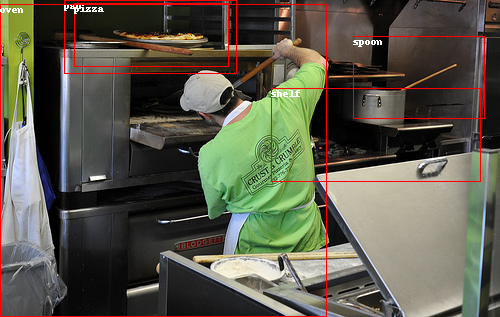

In [8]:
objects = list(question['sceneGraph']['objects'].values())
object_bboxes = get_object_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for i, object in enumerate(objects[:5]):
    bbox = object_bboxes[i]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{object['name']}", fill="white")

imgcopy

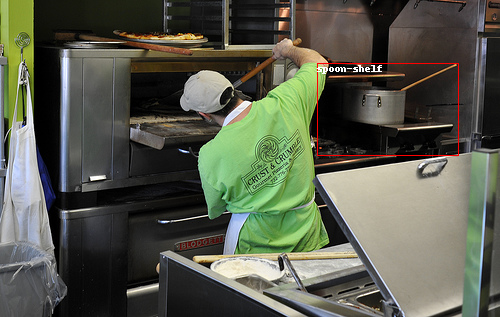

In [9]:
object_pairs = [(2,4)]
pair_bboxes, pair_bbox_indices = get_pair_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object_pair in object_pairs:
    bbox = pair_bboxes[pair_bbox_indices[object_pair[0], object_pair[1]]]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{objects[object_pair[0]]['name']}-{objects[object_pair[1]]['name']}", fill="white")

imgcopy

## Scene Encoding

In [10]:
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import crop, resize, pad
import math


def bboxes_to_image_crops(bboxes, image, mode="pad"):
    bbox_crops = []
    for bbox in bboxes:
        y, x, h, w = int(bbox[0]), int(bbox[1]), int(bbox[2]-bbox[0]), int(bbox[3]-bbox[1])
        bbox_crop = crop(image, y, x, h, w)

        if mode == "pad":
            # resize and scale (maintain aspect ratio)
            if h > w:
                resize_dimensions = (
                    model.img_size, 2*round((model.img_size*w/h)/2))
            else:
                resize_dimensions = (
                    2*round((model.img_size*h/w)/2), model.img_size)
            bbox_crop = resize(bbox_crop, resize_dimensions, antialias=True)

            # pad the image to square dimensions
            bbox_crop = pad(bbox_crop, ((
                model.img_size - resize_dimensions[1])//2, (model.img_size - resize_dimensions[0])//2))

        elif mode == "scale":
            # resize and scale the image to the target dimensions
            bbox_crop = resize(
                bbox_crop, (model.img_size, model.img_size), antialias=True)
        else:
            raise RuntimeError("Unsupported image processing mode!")

        bbox_crops.append(bbox_crop)

    return bbox_crops


def prob_to_asp_weight(prob):
    return int(min(-1000*math.log(prob), 5000))


@torch.no_grad()
def get_scene_encoding(question):
    scene_encoding = ""
    
    scene_graph = question['sceneGraph']
    objects = scene_graph['objects'].values()
    object_items = scene_graph['objects'].items()
    num_objects = len(objects)
    attributes, standalone_values = extract_attributes(question)
    num_attr_values = sum(len(all_attributes.get(attr, [])) for attr in attributes)
    num_standalone_values = len(standalone_values)
    classes = extract_classes(question)
    num_classes = len(classes)
    relations = extract_relations(question)
    num_relations = len(relations)

    for attr in attributes:
        for val in all_attributes.get(attr, []):
            scene_encoding += f"is_attribute_value({cleanup_whitespace(attr)}, {cleanup_whitespace(val)}).\n"
        scene_encoding += "\n"


    image = read_image(f"../data/images/{question['imageId']}.jpg", ImageReadMode.RGB)

    if len(attributes) > 0 or len(standalone_values) > 0 or len(classes) > 0:
        object_bboxes = get_object_bboxes(question)
        obj_bbox_crops = bboxes_to_image_crops(object_bboxes, image)
        attr_prompts = [f"a bad photo of a {val} object"
                        for object in objects
                        for attr in attributes
                        for val in all_attributes.get(attr, [])]
        attr_prompts.append("a bad photo of an object")
        standalone_value_prompts = [f"a bad photo of a {val} object"
                                    for object in objects
                                    for val in standalone_values]
        standalone_value_prompts.append("a bad photo of an object")
        class_prompts = [f"a bad photo of a {class_}" for class_ in classes]
        class_prompts.append("a bad photo of an object")

        obj_logits_per_image = model.score(
            obj_bbox_crops, [*attr_prompts, *standalone_value_prompts, *class_prompts])
            
    if len(relations) > 0:
        rel_bboxes, rel_bbox_indices = get_pair_bboxes(question, merge_threshold=0.6)
        rel_bbox_crops = bboxes_to_image_crops(rel_bboxes, image)
    
    # add attributes derived from object detection (names, vposition/hposition)
    for o1, (oid1, object1) in enumerate(object_items):
        scene_encoding += f"object({oid1}).\n"

        # scene_encoding += f"has_attribute({oid1}, class, {sanitize_asp(object['name'])}).\n"
        scene_encoding += f"has_attribute({oid1}, name, {sanitize_asp(object1['name'])}).\n"

        if (object1['x'] + object1['w']/2) > scene_graph['width']/3*2:
            scene_encoding += f"has_attribute({oid1}, hposition, right).\n"
        elif (object1['x'] + object1['w']/2) > scene_graph['width']/3:
            scene_encoding += f"has_attribute({oid1}, hposition, middle).\n"
        else:
            scene_encoding += f"has_attribute({oid1}, hposition, left).\n"

        if (object1['y'] + object1['h']/2) > scene_graph['height']/3*2:
            scene_encoding += f"has_attribute({oid1}, vposition, bottom).\n"
        elif (object1['y'] + object1['h']/2) > scene_graph['height']/3:
            scene_encoding += f"has_attribute({oid1}, vposition, middle).\n"
        else:
            scene_encoding += f"has_attribute({oid1}, vposition, top).\n"
        scene_encoding += "\n"

        if len(attributes) > 0:    
            attr_scores = torch.stack([
                obj_logits_per_image[o1, o1*(num_attr_values):(o1+1)*num_attr_values],
                obj_logits_per_image[o1, num_objects*num_attr_values].expand(num_attr_values)
            ])
            attr_probs = torch.nn.functional.softmax(attr_scores, dim=0)  

            # print(f"{num_attr_values}, {attr_probs.shape}")

            j = 0
            for attr in attributes:
                for val in all_attributes.get(attr, []): 
                    scene_encoding += f"{{has_attribute({oid1}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)})}}.\n"
                    scene_encoding += f":~ has_attribute({oid1}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)}). [{prob_to_asp_weight(attr_probs[0,j])}, ({oid1}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)})]\n"
                    scene_encoding += f":~ not has_attribute({oid1}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)}). [{prob_to_asp_weight(attr_probs[1,j])}, ({oid1}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)})]\n"
                    j += 1
                
            scene_encoding += "\n"

            del attr_scores, attr_probs

        if len(standalone_values) > 0:
            attr_indices = num_objects*(num_attr_values)+1
            standalone_scores = torch.stack([
                obj_logits_per_image[o1, attr_indices+o1*num_standalone_values:attr_indices+(o1+1)*num_standalone_values],
                obj_logits_per_image[o1, attr_indices+num_objects*num_standalone_values].expand(num_standalone_values)
            ])
            standalone_probs = torch.nn.functional.softmax(standalone_scores, dim=0)

            # print(f"{num_standalone_values}, {standalone_probs.shape}")

            k = 0
            for standalone_value_ in standalone_values:
                scene_encoding += f"{{has_attribute({oid1}, any, {cleanup_whitespace(standalone_value_)})}}.\n"
                scene_encoding += f":~ has_attribute({oid1}, any, {cleanup_whitespace(standalone_value_)}). [{prob_to_asp_weight(standalone_probs[0,k])}, ({oid1}, any, {cleanup_whitespace(standalone_value_)})]\n"
                scene_encoding += f":~ not has_attribute({oid1}, any, {cleanup_whitespace(standalone_value_)}). [{prob_to_asp_weight(standalone_probs[1,k])}, ({oid1}, any, {cleanup_whitespace(standalone_value_)})]\n"
                k += 1

            del standalone_scores, standalone_probs

        if len(classes) > 0:
            attr_standalone_indices = num_objects*(num_attr_values+num_standalone_values)+2
            class_scores = torch.stack([
                obj_logits_per_image[o1, attr_standalone_indices:attr_standalone_indices+num_classes],
                obj_logits_per_image[o1, attr_standalone_indices+num_classes].expand(num_classes)
            ])
            class_probs = torch.nn.functional.softmax(class_scores, dim=0)

            l = 0
            for class_ in classes:
                scene_encoding += f"{{has_attribute({oid1}, class, {cleanup_whitespace(class_)})}}.\n"
                scene_encoding += f":~ has_attribute({oid1}, class, {cleanup_whitespace(class_)}). [{prob_to_asp_weight(class_probs[0,l])}, ({oid1}, class, {cleanup_whitespace(class_)})]\n"
                scene_encoding += f":~ not has_attribute({oid1}, class, {cleanup_whitespace(class_)}). [{prob_to_asp_weight(class_probs[1,l])}, ({oid1}, class, {cleanup_whitespace(class_)})]\n"
                l += 1
            scene_encoding += "\n"

            del class_scores, class_probs

        # get cosine similarities between relations and every object pair's image crop
        if len(relations) > 0:
            rel_prompts = []
            for oid2, object2 in object_items:
                if oid2 != oid1:
                    for rel in relations:
                        rel_prompts.append(f"a bad photo of a {object1['name']} {rel} a {object2['name']}")
                    rel_prompts.append(f"a bad photo of a {object1['name']} and a {object2['name']}")

            rel_logits_per_image = model.score(rel_bbox_crops, rel_prompts)
            
            m = 0
            for o2, (oid2, object2) in enumerate(object_items):
                if oid1 != oid2:
                    rel_scores = torch.stack([
                        rel_logits_per_image[rel_bbox_indices[o1, o2], m*(num_relations+1):m*(num_relations+1)+num_relations],
                        rel_logits_per_image[rel_bbox_indices[o1, o2], m*(num_relations+1)+num_relations].expand(num_relations)
                    ])
                    rel_probs = torch.nn.functional.softmax(rel_scores, dim=0)

                    n = 0
                    for rel in relations:
                        scene_encoding += f"{{has_relation({oid1}, {cleanup_whitespace(rel)}, {oid2})}}.\n"
                        scene_encoding += f":~ has_relation({oid1}, {cleanup_whitespace(rel)}, {oid2}). [{prob_to_asp_weight(rel_probs[0,n])}, ({oid1}, {cleanup_whitespace(rel)}, {oid2})]\n"
                        scene_encoding += f":~ not has_relation({oid1}, {cleanup_whitespace(rel)}, {oid2}). [{prob_to_asp_weight(rel_probs[1,n])}, ({oid1}, {cleanup_whitespace(rel)}, {oid2})]\n"

                        n += 1
                    
                    scene_encoding += "\n"
                    m += 1

                    del rel_scores, rel_probs
                
            del rel_logits_per_image

    try: 
        del obj_logits_per_image
    except:
        pass

    return scene_encoding


## Testing

In [11]:
from encode import encode_question
from clingo.control import Control 
from itertools import islice

with open('../encoding/theory.lp') as theory_file:
    theory = theory_file.read()

num_questions = len(questions)
correct = 0
incorrect = 0

def answer_is_correct(answers, correct_answer):
    correct = False 

    for answer in answers:
        if answer == sanitize_asp(correct_answer): 
            correct = True
        elif (answer == 'to_the_right_of' and correct_answer == 'right') or \
            (answer == 'to_the_left_of' and correct_answer == 'left') or \
            (answer == 'in_front_of' and correct_answer == 'front'):
            correct = True
    return correct 

for qid, question in islice(questions, 0, num_questions):
    print(f"Attempting to solve question {qid}")
    print(f"\tQuestion: {question['question']}")
    print(f"\tSemantic: {question['semanticStr']}")
    if question['semantic'][0]['operation'] == 'select' and question['semantic'][0]['argument'] == 'scene':
        num_questions = num_questions - 1
        print("\tQuestion contains 'scene', skipping ...")
        continue

    ctl = Control()
    ctl.add(theory)

    scene_encoding = get_scene_encoding(question)
    question_encoding = encode_question(question)

    with open(f"../data/encoded_questions/{qid}.lp", "w") as f:
        f.write("% ------ scene encoding ------\n")
        f.write(scene_encoding)
        f.write("\n% ------ question encoding ------\n")
        f.write(question_encoding)

    ctl.add(scene_encoding)
    ctl.add(question_encoding)

    answers = [[]]
    def on_model(model):
        answers[0] = [s.arguments[0].name for s in model.symbols(shown=True)]

    ctl.ground()
    handle = ctl.solve(on_model=on_model, async_ = True)
    has_finished = handle.wait(timeout=10.0)
    
    if not has_finished:
        print("\tSearch was timed out after 10 seconds!")
    
    if len(answers[0]) > 0:
        if(answer_is_correct(answers[0], question['answer'])):
            print(f"\tResult: correct answer - {answers[0][0]}")
            correct = correct + 1
        else: 
            print(f"\tResult: incorrect answer - {answers[0][0]} (correct: {question['answer']})")
            incorrect = incorrect + 1
    else: 
        print(f"\tResult: UNSAT")
        incorrect = incorrect + 1

print("===============================")
print(f"Total questions: {num_questions}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Percentage: {correct/num_questions*100}%")

Attempting to solve question 07787914
	Question: Do you see a door that is not red?
	Semantic: select: door (2102911)->filter color: not(red) [0]->exist: ? [1]
	Result: correct answer - no
Attempting to solve question 19560907
	Question: Who is wearing a shirt?
	Semantic: select: shirt (1282189)->relate: person,wearing,s (1282164) [0]->query: name [1]
	Result: incorrect answer - tie (correct: man)
Attempting to solve question 07328145
	Question: What is the watercraft to the left of the cabin?
	Semantic: select: cabin (800346)->relate: watercraft,to the left of,s (800339) [0]->query: name [1]
	Result: incorrect answer - cabin (correct: boats)
Attempting to solve question 17680743
	Question: What is the pan on?
	Semantic: select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]
	Result: incorrect answer - apron (correct: oven)
Attempting to solve question 09455791
	Question: What is on the sofa?
	Semantic: select: sofa (672224)->relate: _,on,s (672232) [0]->query: name [1]
	Re